In [24]:
!pip uninstall tensorflow 
!pip install tensorflow==2.2.0 

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 4.7 kB/s 
     |████████████████████████████████| 454 kB 74.6 MB/s 
     |████████████████████████████████| 2.9 MB 47.4 MB/s 
     |████████████████████████████████| 3.0 MB 42.4 MB/s 
     |████████████████████████████████| 26.1 MB 1.2 MB/s 
     |████████████████████████████████| 152 kB 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose,  MaxPool2D, Concatenate
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [2]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [3]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [4]:
def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.get_layer("input_1").output       ## 256
    s2 = densenet.get_layer("conv1/relu").output    ## 128
    s3 = densenet.get_layer("pool2_relu").output    ## 64
    s4 = densenet.get_layer("pool3_relu").output    ## 32

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 16

    """ Decoder """
    d1 = decoder_block(b1, s4, 256)             ## 32
    d2 = decoder_block(d1, s3, 128)             ## 64
    d3 = decoder_block(d2, s2, 64)             ## 128
    d4 = decoder_block(d3, s1, 32)              ## 256

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

In [5]:
if __name__ == "__main__":
    input_shape = (224, 224, 3)
    model = build_densenet121_unet(input_shape)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [6]:
from glob import glob
import cv2

In [7]:
!mkdir '/content/salamm'
!mkdir '/content/salamm/image_file'
!mkdir '/content/salamm/mask_file'
!cp "/content/drive/MyDrive/nct/project_folder/image_salam.tif" "/content/salamm"
!cp "/content/drive/MyDrive/nct/project_folder/annotation_salam.tif" "/content/salamm"  

mkdir: cannot create directory ‘/content/salamm’: File exists
mkdir: cannot create directory ‘/content/salamm/image_file’: File exists
mkdir: cannot create directory ‘/content/salamm/mask_file’: File exists


In [8]:
from PIL import Image, ImageSequence

im = Image.open("/content/salamm/image_salam.tif")   #/content/salam/image.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/salamm/image_file/Page%d.png" % i)

In [9]:
from PIL import Image, ImageSequence

im = Image.open("/content/salamm/annotation_salam.tif")   #/content/salam/image.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/salamm/mask_file/Page%d.png" % i)

In [10]:
masks_paths= glob('/content/salamm/mask_file/*')     #masks_paths= glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
images_paths= glob('/content/salamm/image_file/*')
#cell_paths= glob('/content/salamm/20_cells/*')
#images_paths=[path.replace("_mask","") for path in masks_paths]
print(f"The no of mask images is {len(masks_paths)}.")
print(f"The no of images is {len(images_paths)}.")
#print(f"The no of cell_1 images is{len(cell_paths)}.")

The no of mask images is 80.
The no of images is 80.


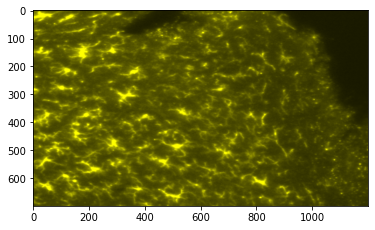

In [11]:
import matplotlib.pyplot as plt
import numpy
img=plt.imread(images_paths[17])
#msk=cv2.imread(masks_paths[17])
plt.imshow(img)
#plt.imshow(msk, alpha=0.2)  #plt.imshow(msk,alpha=0.5)
plt.show()

In [12]:
import pandas as pd
import numpy as np

In [13]:
#ataFrame=pd.DataFrame({"images":images_paths,"mask":masks_paths,"diagnosis":[1 if (np.max(cv2.imread(imagepath))>0) else 0 for imagepath in masks_paths]})
DataFrame_df = pd.DataFrame({'images':images_paths,'masks':masks_paths})

In [14]:
DataFrame_df.head(30)

,images,masks
0,/content/salamm/image_file/Page59.png,/content/salamm/mask_file/Page59.png
1,/content/salamm/image_file/Page3.png,/content/salamm/mask_file/Page3.png
2,/content/salamm/image_file/Page27.png,/content/salamm/mask_file/Page27.png
3,/content/salamm/image_file/Page79.png,/content/salamm/mask_file/Page79.png
4,/content/salamm/image_file/Page25.png,/content/salamm/mask_file/Page25.png
5,/content/salamm/image_file/Page28.png,/content/salamm/mask_file/Page28.png
6,/content/salamm/image_file/Page66.png,/content/salamm/mask_file/Page66.png
7,/content/salamm/image_file/Page1.png,/content/salamm/mask_file/Page1.png
8,/content/salamm/image_file/Page52.png,/content/salamm/mask_file/Page52.png
9,/content/salamm/image_file/Page77.png,/content/salamm/mask_file/Page77.png


In [15]:
from sklearn.model_selection import train_test_split
traindata,testdata=train_test_split(DataFrame_df,test_size=0.1,random_state=42)
traindata,valdata=train_test_split(traindata,test_size=0.1,random_state=42)

In [16]:
print('Train.shape: {}\nTest.shape: {}'.format(traindata.shape, testdata.shape))  

Train.shape: (64, 2)
Test.shape: (8, 2)


In [17]:
print(f"train size is {len(traindata)},val size is {len(valdata)},test size is {len(testdata)}")

train size is 64,val size is 8,test size is 8


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)


def trainDataGeneration(traindata):
    
    ##Data Augmentation
    image_datagen = ImageDataGenerator(dict(rotation_range=0.2,
                                        rescale=1./255,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest'))
    mask_datagen = ImageDataGenerator(dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest'))

    ##flow the images from paths 
    image_generator = image_datagen.flow_from_dataframe(
    traindata,
    x_col = "images",
    class_mode = None,
    color_mode = "rgb",
    target_size = (224,224),
    batch_size = 16,seed=42
    )
    mask_generator = mask_datagen.flow_from_dataframe(
    traindata,
    x_col = "masks",
    class_mode = None,
    color_mode = "grayscale",
    target_size = (224,224),
    batch_size = 16,seed=42
    )
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = adjust_data(img, mask)
        yield (img,mask)
def testDataGeneration(valdata):
    image_datagen = ImageDataGenerator(dict())
    mask_datagen = ImageDataGenerator(dict())
    image_generator = image_datagen.flow_from_dataframe(
        valdata,
        x_col = "images",
        class_mode = None,
        color_mode = 'rgb',
        target_size = (224,224),
        batch_size = 16,
        seed = 42)

    mask_generator = mask_datagen.flow_from_dataframe(
        valdata,
        x_col = "masks",
        class_mode = None,
        color_mode = "grayscale",
        target_size = (224,224),
        batch_size = 16,
        seed = 42)
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = adjust_data(img, mask)
        yield (img,mask)

In [20]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [21]:
trainingdata=trainDataGeneration(traindata)
validationdata=testDataGeneration(valdata)

In [ ]:
BATCH_SIZE = 16
epochs=100
learning_rate=0.001
decay_rate = learning_rate / epochs
model.compile(optimizer=Adam(lr=learning_rate,decay=decay_rate), loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
callbacks = [ModelCheckpoint('brainSeg.hdf5', verbose=1, save_best_only=True)]
history = model.fit(trainingdata,
                    steps_per_epoch=len(traindata) / BATCH_SIZE, 
                    epochs=epochs, 
                    callbacks=callbacks,
                    validation_data = validationdata,
                    validation_steps=len(valdata) / BATCH_SIZE)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: -0.0146 - binary_accuracy: 0.5576 - iou: 0.0075 - dice_coef: 0.0146 
Epoch 00001: val_loss improved from inf to -0.01187, saving model to brainSeg.hdf5
4/4 [==============================] - 71s 18s/step - loss: -0.0146 - binary_accuracy: 0.5576 - iou: 0.0075 - dice_coef: 0.0146 - val_loss: -0.0119 - val_binary_accuracy: 0.0046 - val_iou: 0.0062 - val_dice_coef: 0.0119
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: -0.0220 - binary_accuracy: 0.8429 - iou: 0.0113 - dice_coef: 0.0220 
Epoch 00002: val_loss did not improve from -0.01187
4/4 [==============================] - 72s 18s/step - loss: -0.0220 - binary_accuracy: 0.8429 - iou: 0.0113 - dice_coef: 0.0220 - val_loss: -0.0111 - val_binary_accuracy: 0.0046 - val_iou: 0.0057 - val_dice_coef: 0.0111
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: -0.0278 - binary_accuracy: 0.8854 - iou: 0.0143 - dice_coef: 0.0278 
Epoch 00003: val_